# Mean Carbon sequestration time

### 1. Load environmental data

### 2. Calculate the POC flux at each 3D cell

### 3. Calculate the injection of POC in each 3D cell

### 4. Calculate the mean sequestration time at each location 

In [1]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import math

In [2]:
#ok sous base aussi
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Cannot find header.dxf (GDAL_DATA is not defined)


In [3]:
# To be change with local directory of the data (file too heavy to be on git)
import os
os.chdir('./Key_Areas_krill_carbon_sequestration/outputs_formated_data/')

# Load environmental data

- load formated OCIM data
- load formated physical data (T)
- load formated biogeochemical data (O2)

We load the formated data (see the corresponding files for formating methodologies). 
In brief, all three (krill biomass density, krill catch, temperature, MLD , O2 and time of sequestration) are formated on a spatial grid of 2°x2° resoltuion, with longitude on a atlantic centered format and both latitude and longitude on odd number.

And transform arrays into Dataframe for easier manipulations.

In [4]:
OCIM = xr.open_dataset('fseq_OCIM2_48L_interpolated_SO.nc')
MLD = xr.open_dataset('MLD_summer_SO_interpolated.nc')
thetao = xr.open_dataset('thetao_summer_SO_interpolated.nc')
oxygen = xr.open_dataset('oxygen_summer_SO_interpolated.nc')

In [5]:
OCIM

<xarray.Dataset>
Dimensions:        (ocean grid point: 405386, time: 1001, latitude: 20,
                    longitude: 180, depth: 48)
Coordinates:
  * longitude      (longitude) float64 -179.0 -177.0 -175.0 ... 177.0 179.0
  * depth          (depth) float64 4.935 14.88 25.12 ... 5.253e+03 5.582e+03
  * latitude       (latitude) int32 -79 -77 -75 -73 -71 ... -49 -47 -45 -43 -41
Dimensions without coordinates: ocean grid point, time
Data variables:
    fseq           (ocean grid point, time) float64 ...
    MASK           (latitude, longitude, depth) float64 ...
    LAT            (latitude, longitude, depth) float64 ...
    LON            (latitude, longitude, depth) float64 ...
    DEPTH          (latitude, longitude, depth) float64 ...
    VOL            (latitude, longitude, depth) float64 ...
    AREA           (latitude, longitude, depth) float64 ...
    mean_seq_time  (latitude, longitude, depth) float64 ...

In [6]:
MLD

<xarray.Dataset>
Dimensions:    (latitude: 20, longitude: 180)
Coordinates:
  * latitude   (latitude) int32 -79 -77 -75 -73 -71 -69 ... -49 -47 -45 -43 -41
  * longitude  (longitude) int32 -179 -177 -175 -173 -171 ... 173 175 177 179
Data variables:
    mlotst     (latitude, longitude) float64 ...

In [7]:
thetao

<xarray.Dataset>
Dimensions:    (latitude: 20, longitude: 180, depth: 49)
Coordinates:
  * latitude   (latitude) int32 -79 -77 -75 -73 -71 -69 ... -49 -47 -45 -43 -41
  * longitude  (longitude) int32 -179 -177 -175 -173 -171 ... 173 175 177 179
  * depth      (depth) float64 0.494 9.869 19.89 ... 5.414e+03 5.75e+03
Data variables:
    thetao     (depth, latitude, longitude) float64 ...

In [8]:
oxygen

<xarray.Dataset>
Dimensions:    (latitude: 20, longitude: 180, depth: 49)
Coordinates:
  * latitude   (latitude) int32 -79 -77 -75 -73 -71 -69 ... -49 -47 -45 -43 -41
  * longitude  (longitude) int32 -179 -177 -175 -173 -171 ... 173 175 177 179
  * depth      (depth) float64 0.5058 9.869 19.89 ... 5.414e+03 5.75e+03
Data variables:
    o2         (depth, latitude, longitude) float32 ...

In [9]:
# transform the xarrays in datasets
# For OCIM data
time_seq = OCIM['mean_seq_time']
df_time_seq = time_seq.to_dataframe()


# for temperature data + correct the longitude coordinates
df_thetao = thetao.to_dataframe()

# for MLD
df_MLD = MLD.to_dataframe()

# for oxygen
df_oxygen = oxygen.to_dataframe()

### Join datarframes together

We will make two dataframes:
- **temperature + oxygene + MLD with depth = OCIM bounds of depth layers => used to computed the POC flux** \
Then the Injection within each layer is calculated (between two layers bounds)
Note that here temperature and oxygen datset doesn't not have the exact same first depth (the upper one, i.e., the surface).
This is because the original datasets do not have the same first value for depth.
and the interpolation cannot be performed outised the original range of the data.
Thus the first depth will be droped when removing the NAN. This is not a problem as the POC attenuation is accounted from the MLD that is alsways deeper 
(or even from an fixed value of 20m depth (like in Belcher et al 2019) that is deeper that the second depth value (9.87 m))


- **ocim time seq, with depth = ocim middel depth layers => used to calculate the mean time of sequestration**

In [10]:
df_envir = df_thetao.join(other = df_MLD, how='left')
df_envir =  df_envir.join(other = df_oxygen, how='left')

#drop NAN = cells on land or below seabed 
df_envir = df_envir.dropna().reset_index() # 103751 rows × 5 columns

# do the sae for ocim data
df_time_seq = df_time_seq.dropna().reset_index() # 111316 rows × 4 columns

In [11]:
df_envir #  104198 row

,latitude,longitude,depth,thetao,mlotst,o2
0,-75,-179,9.869082,-1.182452,35.121723,339.077637
1,-75,-179,19.885876,-1.237982,35.121723,333.576447
2,-75,-179,30.345807,-1.361431,35.121723,323.271240
3,-75,-179,41.544299,-1.390695,35.121723,311.738403
4,-75,-179,53.776778,-1.286125,35.121723,303.001831
...,...,...,...,...,...,...
104193,-41,179,2015.508640,2.265531,25.279501,155.380341
104194,-41,179,2186.236439,2.041283,25.279501,156.583969
104195,-41,179,2366.860963,1.879878,25.279501,161.340530
104196,-41,179,2557.677636,1.735873,25.279501,169.932449


## Create (or load) the chosen attenuation function 

In the script "POC attenuation exploration" we tested different parametrization of the attenuation curve, and the sensibility of parameters. We chose one set of parameters to compute the POC flux and the mean seuestration time that will be used in the rest of the analysis.

#### The attenuation function is written

$$ 𝐹𝐹𝑃_{𝑧} = 𝑓𝑝𝑝 \times 𝑒^{(-\frac{𝑘𝑟𝑒𝑚𝑖𝑛}{𝑊𝑠𝑖𝑛𝑘} \times T_{dep} \times O2_{dep} \times (𝑧 − 𝑧_{0}))} $$

- Terme of temperature dependance :

$T_{dep} = Q_{10}^{\frac{T-T_{ref}}{10}}$
with $T_{ref}$ a temperature of reference.

- Terme of oxygen dependance :

$O2_{dep} = \frac{[O_2]}{[O_2] + K_{O2}} $ 

#### The Final set of parameter is

$k_remin_ref = 0.3$ /day

$Q10 = 2$ no units

$Tref = 5$ °C

$ffp_z0 = 100$ arbitrary initial flux (mgC/m²/day) => so the $ 𝐹𝐹𝑃_{𝑧}$ can be directly interpretated as the remaining % of POC production.

$wsink = 233$ m/day

$KO2 = 9.9$ µmol/L

$z_0 = local MLD$ m

In [12]:
# tests with different starting depth 
# z = a given depth at wich the flux is calculated
#z0 = the starting depth of the attenuation curve
# dep = str to indicate which environnemental drivers should be considered : N=None, T= Temp only, O= O2 only, TO=temp and O2
# ffp0 = the POC flux at the starting depth
# Tloc and O2loc = the local temperature and O2 level (if needed)

def attenuation(z, z0, ffp0, Tloc, O2loc):
    remin_rate = ((-k_remin_ref)/(wsink)) * (Q10**((Tloc-Tref)/10)) * ((O2loc)/(O2loc+KO2))  
    ffpz = ffp0*math.exp(remin_rate*(z-z0))
    return(ffpz)

In [13]:
# Values of parameters 
k_remin_ref = 0.3 # /day
wsink = 233 # m/day

Q10 = 2 # no units
Tref = 5 # °C

KO2 = 9.9 #µmol/L

### Apply the attenuation function 

In [14]:
POC_flux = []

for index in np.arange(0, df_envir.shape[0]): # df_envir.shape[0] = 104198 = nb of rows
    local_temp = df_envir['thetao'].iloc[index]
    local_oxygen = df_envir['o2'].iloc[index]
    local_depth = df_envir['depth'].iloc[index]
    local_MLD = df_envir['mlotst'].iloc[index]
    
    if local_depth<local_MLD:
        poc = 100 # 100% of the initial value of the poc flux
        POC_flux.append(poc)
    else :
        poc = attenuation(z=local_depth, z0=local_MLD, ffp0=100, Tloc=local_temp, O2loc=local_oxygen)
        POC_flux.append(poc)
    
# Add to the dataset
df_envir['POC_flux'] = POC_flux
df_envir

,latitude,longitude,depth,thetao,mlotst,o2,POC_flux
0,-75,-179,9.869082,-1.182452,35.121723,339.077637,100.000000
1,-75,-179,19.885876,-1.237982,35.121723,333.576447,100.000000
2,-75,-179,30.345807,-1.361431,35.121723,323.271240,100.000000
3,-75,-179,41.544299,-1.390695,35.121723,311.738403,99.486665
4,-75,-179,53.776778,-1.286125,35.121723,303.001831,98.506844
...,...,...,...,...,...,...,...
104193,-41,179,2015.508640,2.265531,25.279501,155.380341,13.627327
104194,-41,179,2186.236439,2.041283,25.279501,156.583969,11.863895
104195,-41,179,2366.860963,1.879878,25.279501,161.340530,10.145291
104196,-41,179,2557.677636,1.735873,25.279501,169.932449,8.567205


### Calculate the injection of POC in each 3D cell

The injection is defined as the carbon "lost" between two depth. We can write the injection of carbone in the layer i, defined  between the depths z-1 and z as

$$ Injection_i = FFP_z - FFP_{z+1} $$ 

In the last layer we hypothesize that the remaining POC is entirely remineralised. To do this we have to localize in the dataset the position of the maximal depth at each location and then modify to injection as the whole rest of POC reaching the last depth layer.

In [15]:
df_envir['injection'] = np.insert(np.diff(df_envir['POC_flux']), 0, 0) # add a 0 for the first value (to match the index of depth)
df_envir

,latitude,longitude,depth,thetao,mlotst,o2,POC_flux,injection
0,-75,-179,9.869082,-1.182452,35.121723,339.077637,100.000000,0.000000
1,-75,-179,19.885876,-1.237982,35.121723,333.576447,100.000000,0.000000
2,-75,-179,30.345807,-1.361431,35.121723,323.271240,100.000000,0.000000
3,-75,-179,41.544299,-1.390695,35.121723,311.738403,99.486665,-0.513335
4,-75,-179,53.776778,-1.286125,35.121723,303.001831,98.506844,-0.979821
...,...,...,...,...,...,...,...,...
104193,-41,179,2015.508640,2.265531,25.279501,155.380341,13.627327,-1.806655
104194,-41,179,2186.236439,2.041283,25.279501,156.583969,11.863895,-1.763432
104195,-41,179,2366.860963,1.879878,25.279501,161.340530,10.145291,-1.718604
104196,-41,179,2557.677636,1.735873,25.279501,169.932449,8.567205,-1.578086


In [16]:
# drop the '100' in POC to remove the depths above the MLD
df_envir = df_envir[df_envir.POC_flux != 100]
df_envir

,latitude,longitude,depth,thetao,mlotst,o2,POC_flux,injection
3,-75,-179,41.544299,-1.390695,35.121723,311.738403,99.486665,-0.513335
4,-75,-179,53.776778,-1.286125,35.121723,303.001831,98.506844,-0.979821
5,-75,-179,67.338668,-1.134901,35.121723,298.192444,97.409995,-1.096849
6,-75,-179,82.525393,-0.959095,35.121723,295.323853,96.168103,-1.241892
7,-75,-179,99.632379,-0.772767,35.121723,293.357422,94.757199,-1.410904
...,...,...,...,...,...,...,...,...
104193,-41,179,2015.508640,2.265531,25.279501,155.380341,13.627327,-1.806655
104194,-41,179,2186.236439,2.041283,25.279501,156.583969,11.863895,-1.763432
104195,-41,179,2366.860963,1.879878,25.279501,161.340530,10.145291,-1.718604
104196,-41,179,2557.677636,1.735873,25.279501,169.932449,8.567205,-1.578086


In [17]:
# Find the location of the maximal depth at each location
# i.e., the depth goes up, until we change location
loc_max_depth = df_envir[1:-1][np.diff(np.diff(df_envir['depth'])) < 0].index
loc_max_depth # length=2740

Index([    17,     35,     61,     91,    122,    157,    194,    232,    272,
          312,
       ...
       103858, 103901, 103944, 103986, 104029, 104071, 104100, 104123, 104135,
       104160],
      dtype='int64', length=2726)

In [18]:
df_to_update = df_envir.loc[loc_max_depth][['latitude', 'longitude', 'depth', 'POC_flux', 'injection']]
df_to_update['injection'] = df_to_update['injection']-df_to_update['POC_flux'] # do not run multiple times !
df_to_update

,latitude,longitude,depth,POC_flux,injection
17,-75,-179,441.309963,72.012752,-74.721527
35,-75,-177,441.309963,68.151004,-71.561185
61,-75,-175,1072.706694,38.292515,-41.973201
91,-75,-173,1559.751351,25.019882,-28.171466
122,-75,-171,1702.561521,22.045075,-24.993187
...,...,...,...,...,...
104071,-41,165,3933.156612,2.748758,-3.429957
104100,-41,167,1425.656208,21.835227,-24.085727
104123,-41,169,787.557135,34.414888,-36.746224
104135,-41,171,193.171415,69.252840,-73.170783


In [19]:
df_envir.update(df_to_update, overwrite = True)
df_envir.loc[loc_max_depth]

,latitude,longitude,depth,thetao,mlotst,o2,POC_flux,injection
17,-75,-179,441.309963,-1.239093,35.121723,294.263824,72.012752,-74.721527
35,-75,-177,441.309963,0.902917,30.696539,261.111420,68.151004,-71.561185
61,-75,-175,1072.706694,0.949249,44.531597,238.550613,38.292515,-41.973201
91,-75,-173,1559.751351,0.712687,51.143936,238.348206,25.019882,-28.171466
122,-75,-171,1702.561521,0.681109,52.313816,237.612335,22.045075,-24.993187
...,...,...,...,...,...,...,...,...
104071,-41,165,3933.156612,0.852555,23.295799,195.110321,2.748758,-3.429957
104100,-41,167,1425.656208,3.334461,22.253080,170.611862,21.835227,-24.085727
104123,-41,169,787.557135,6.800015,20.879747,204.522186,34.414888,-36.746224
104135,-41,171,193.171415,12.799682,19.124933,209.227371,69.252840,-73.170783


### matching depths

The depths in the envir data and the time seq data are different : the depths in the envir data are the OCIM boundaries, and the depths in the time seq data is the median depth of each ocim layers.
We create a dataset to make them match and be abale to join the dataframes by locations and depths.

In [20]:
data = {'depth': np.unique(df_envir.depth), 
        # the shallowest and the 2 depest depth are not present, so we remove them from OCIM depths
        'depth_median': np.delete(np.asarray(OCIM['depth']), [0, -1, -2])} 
matching_depths = pd.DataFrame(data)
matching_depths

,depth,depth_median
0,19.885876,14.877479
1,30.345807,25.115841
2,41.544299,35.945053
3,53.776778,47.660539
4,67.338668,60.557723
5,82.525393,74.932031
6,99.632379,91.078886
7,118.955049,109.293714
8,140.788829,129.871939
9,165.429142,153.108986


In [21]:
# merge the dataframe together to add the 'median depth' of the ocim layers 
# note that here, it also reset the index from 0 (before it started at 3 from when we removed the rows above the MLD)
df_envir = df_envir.merge(matching_depths, on = 'depth', how = 'left')
df_envir

,latitude,longitude,depth,thetao,mlotst,o2,POC_flux,injection,depth_median
0,-75,-179,41.544299,-1.390695,35.121723,311.738403,99.486665,-0.513335,35.945053
1,-75,-179,53.776778,-1.286125,35.121723,303.001831,98.506844,-0.979821,47.660539
2,-75,-179,67.338668,-1.134901,35.121723,298.192444,97.409995,-1.096849,60.557723
3,-75,-179,82.525393,-0.959095,35.121723,295.323853,96.168103,-1.241892,74.932031
4,-75,-179,99.632379,-0.772767,35.121723,293.357422,94.757199,-1.410904,91.078886
...,...,...,...,...,...,...,...,...,...
93918,-41,179,2015.508640,2.265531,25.279501,155.380341,13.627327,-1.806655,1934.945391
93919,-41,179,2186.236439,2.041283,25.279501,156.583969,11.863895,-1.763432,2100.872539
93920,-41,179,2366.860963,1.879878,25.279501,161.340530,10.145291,-1.718604,2276.548701
93921,-41,179,2557.677636,1.735873,25.279501,169.932449,8.567205,-1.578086,2462.269300


In [22]:
# keep neede variable to join with OCIM dataset
df_envir = df_envir[['latitude', 'longitude','depth_median', 'injection']]

#renam depth so it matches the names is envir dataset
df_time_seq = df_time_seq.rename(columns={"depth": "depth_median"})

# join the time seq data set on depth_median 
df_final = df_envir.merge(df_time_seq, on = ['latitude', 'longitude','depth_median'], how = 'left')
df_final

,latitude,longitude,depth_median,injection,mean_seq_time
0,-75,-179,35.945053,-0.513335,0.033683
1,-75,-179,47.660539,-0.979821,0.039898
2,-75,-179,60.557723,-1.096849,0.046942
3,-75,-179,74.932031,-1.241892,0.057227
4,-75,-179,91.078886,-1.410904,0.087150
...,...,...,...,...,...
93918,-41,179,1934.945391,-1.806655,598.342438
93919,-41,179,2100.872539,-1.763432,685.383478
93920,-41,179,2276.548701,-1.718604,809.636526
93921,-41,179,2462.269300,-1.578086,NaN


## Calculate the mean sequestration time at each location (2D cell)

In oder to calculate the mean sequestration time at each location, we can compute the average sequestration time over depth, weighted by injection in each depth layer and location.

$$ \sum_{depth=z_0}^{maxdepth} Injection_{depth} \times Time~ seq_{depth} = Mean ~ sequestration ~ time $$


In [23]:
#def a function to calculate the weighted mean on a dataframe
def weighted_average(dataframe, value, weight):
    val = dataframe[value]
    wt = dataframe[weight]
    return (val * wt).sum() / wt.sum()

In [24]:
# group by location (couple of latitude and longitude) and apply the weighted mean function
df_2D = df_final.groupby(['latitude', 'longitude'])
df_2D = df_2D.apply(weighted_average, value = 'mean_seq_time', weight = 'injection').to_frame('mean_seq_time')
df_2D

mean_seq_time
latitude longitude               
-75      -179          626.935802
         -177          580.087296
         -175          624.671974
         -173          609.160716
         -171          586.865837
...                           ...
-41       167          161.097105
          169           62.327443
          171           31.141974
          177           74.543068
          179          115.692143

[2727 rows x 1 columns]

In [25]:
# check negative values
null_neg_values = df_2D[(df_2D['mean_seq_time'] < 0)]
null_neg_values

mean_seq_time
latitude longitude               
-73      -59           -44.188197
-71      -59           -10.633472
         -57           -65.804556
-69      -57           -14.248040
-67       65            -0.139167
-63      -59           -33.664816
-49      -65            -0.692066
-47      -65            -0.009011
-45      -65            -0.000041

In [26]:
# assign 0 to all of them
df_2D.loc[df_2D['mean_seq_time'] < 0, 'mean_seq_time'] = 0

### Cut the latitude at -50° S to be more coherant with the krill spatial distribution

In [27]:
df_2D = df_2D.reset_index()
df_2D = df_2D[df_2D['latitude'] <=-45].set_index(['latitude', 'longitude'])
df_2D # 1860 

mean_seq_time
latitude longitude               
-75      -179          626.935802
         -177          580.087296
         -175          624.671974
         -173          609.160716
         -171          586.865837
...                           ...
-45       167           -0.000000
          173          143.945108
          175          117.774518
          177          181.254588
          179          114.439852

[2384 rows x 1 columns]

#### Transform the datasets in xarray to plot

In [28]:
# Store the results in xarray to plot it
#creat a new xarray
xr_mean_time_seq_final = xr.Dataset.from_dataframe(df_2D) # convert into xarrayDataset
xr_mean_time_seq_final = xr.Dataset.to_array(xr_mean_time_seq_final)
xr_mean_time_seq_final

<xarray.DataArray (variable: 1, latitude: 16, longitude: 180)>
array([[[626.93580212, 580.08729589, 624.67197397, ..., 408.16880743,
         518.75957089, 611.63361404],
        [622.72402233, 561.01276307, 615.70393454, ..., 707.10107201,
         719.02349755, 710.47146472],
        [646.15745626, 606.13601954, 490.22474523, ..., 600.93050065,
         727.28237379, 686.45565666],
        ...,
        [217.46573725, 227.78282614, 198.14701991, ...,  62.38493961,
         185.6301526 ,  49.25706899],
        [202.78552633, 166.69823089, 172.73438448, ..., 191.8115567 ,
         161.8712533 , 119.25605614],
        [177.77336976, 161.4295094 , 205.31176662, ..., 117.77451816,
         181.25458772, 114.43985222]]])
Coordinates:
  * latitude   (latitude) int32 -75 -73 -71 -69 -67 -65 ... -53 -51 -49 -47 -45
  * longitude  (longitude) int32 -179 -177 -175 -173 -171 ... 173 175 177 179
  * variable   (variable) object 'mean_seq_time'

Text(0.5, 1.0, 'Map of the mean time of carbon sequestration')

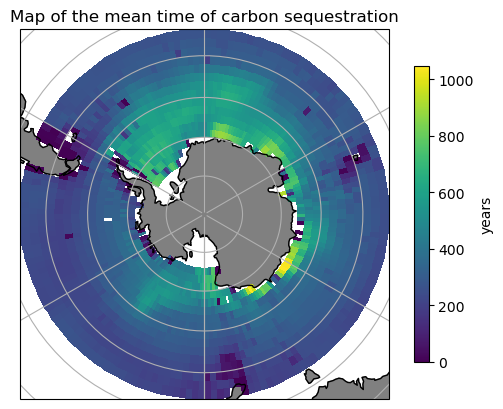

In [29]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.SouthPolarStereo()

p = xr_mean_time_seq_final.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    #cmap="PuBu",
    #title = 'mean time of carbon sequesration'
)  # the plot's projection

#p.axes.coastlines()
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'years', shrink = 0.8)
plt.title('Map of the mean time of carbon sequestration')

In [30]:
# Save the data
os.chdir('./Key_Areas_krill_carbon_sequestration/sensitivity_analyses/')
xr_mean_time_seq_final.to_netcdf('Mean_time_seq_high_Kremin.nc')